<a href="https://colab.research.google.com/github/daeunni/Statistical_DL/blob/main/lec_code/13_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **VAE (Variational Auto Encoder)**
- 입력변수의 분포와 분포의 모수를 동시에 추정하는 것이 목표
- 근사분포가 실제 사전 분포를 얼마나 잘 근사하느냐가 VAE의 성능을 좌우! 
> 두 분포간의 거리 측정을 위해서는 **Kullback - Leibler(KL) divergence** 이용

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as k
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import numpy as np

In [2]:
img_shape=(28,28,1)
batch_size=16
latent_dim=2

input_img=layers.Input(shape=img_shape)
x=layers.Conv2D(32,3,padding='same', strides=2, activation='relu')(input_img)
x=layers.Conv2D(64,3, padding='same', strides=2, activation='relu')(x)
shape=k.int_shape(x)
x=layers.Flatten()(x)
x=layers.Dense(32, activation='relu')(x)

# latent variable
z_mean=layers.Dense(latent_dim)(x)  # 잠재변수 z의 평균
z_log_var=layers.Dense(latent_dim)(x)  # 잠재변수 z의 분산

잠재변수 z의 생성과 은닉층 추가

In [3]:
def sampling(args):
    z_mean,z_log_var=args
    batch=k.shape(z_mean)[0]
    dim=k.int_shape(z_mean)[1]
    epsilon=tf.random.normal(shape=(batch,dim))
    return z_mean+tf.exp(0.5*z_log_var)*epsilon
z=layers.Lambda(sampling,output_shape=(latent_dim,))([z_mean,z_log_var])   # keras에 built-in 되어있지 않아 Lambda를 호출해 은닉층으로 추가

## Encoder

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
______________________________________________________________________________________________

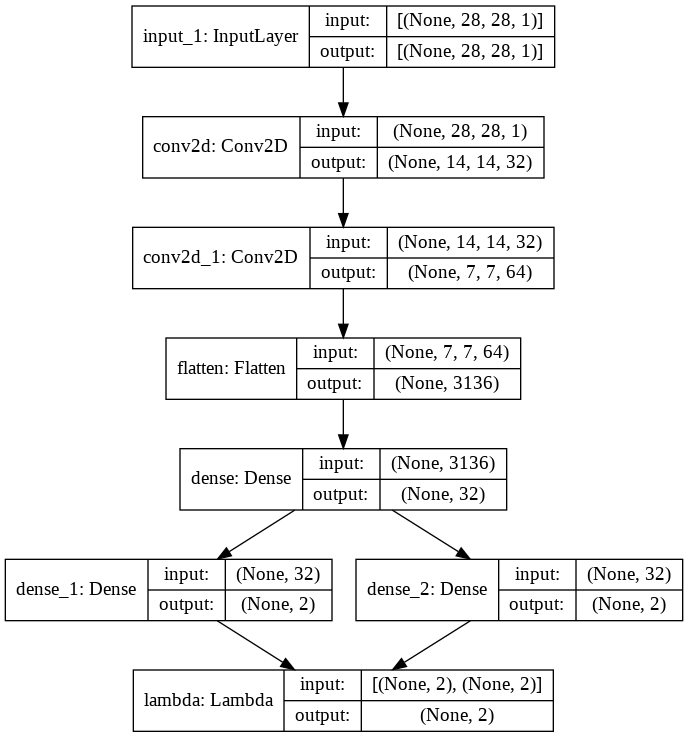

In [4]:
encoder=Model(input_img,[z_mean, z_log_var, z])
encoder.summary()
plot_model(encoder,show_shapes=True)

## Decoder

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

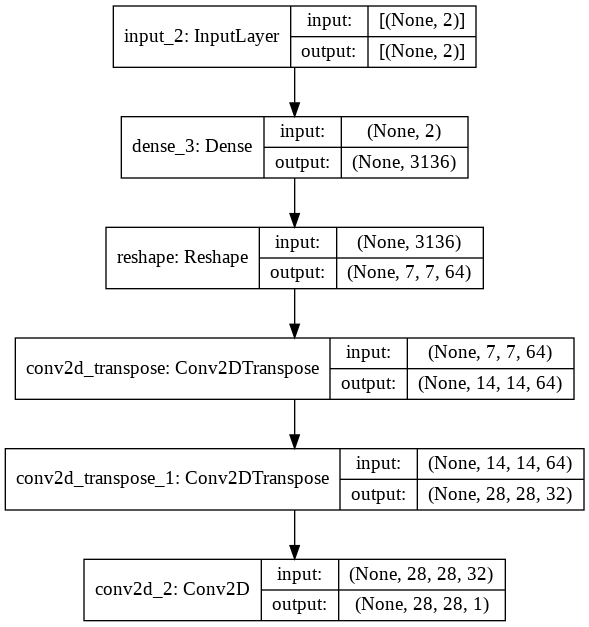

In [5]:
latent_input=layers.Input(shape=(latent_dim,))

x=layers.Dense(np.prod(shape[1:]), activation='relu')(latent_input)
x=layers.Reshape(shape[1:])(x)

x=layers.Conv2DTranspose(64,3,padding='same',strides=2,activation='relu')(x)
x=layers.Conv2DTranspose(32,3,padding='same',strides=2,activation='relu')(x)

output=layers.Conv2D(1,3, padding='same',activation='sigmoid')(x)
decoder=Model(latent_input,output)
decoder.summary()
plot_model(decoder, show_shapes=True)

In [6]:
f_output=decoder(encoder(input_img)[2])  # 최종 출력은 input과 동일한 (28, 28, 1) 3d tensor 출력
vae=Model(input_img, f_output)  
vae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Functional)           [(None, 2), (None, 2), (N 119332    
_________________________________________________________________
model_1 (Functional)         (None, 28, 28, 1)         65089     
Total params: 184,421
Trainable params: 184,421
Non-trainable params: 0
_________________________________________________________________


VAE의 추론손실 추가 (add_loss 함수 이용)

In [7]:
inference_loss=1+z_log_var-tf.square(z_mean)-tf.exp(z_log_var)
inference_loss=k.sum(inference_loss, axis=-1)*-0.5/(input_img.shape[1]*input_img.shape[1])

vae.add_loss(k.mean(inference_loss))   # add_loss를 이용해 추론손실 정의 
vae.compile(loss='mse', optimizer='rmsprop')

In [8]:
from tensorflow.keras.datasets import mnist

(x_train,_),(x_test,y_test)=mnist.load_data()
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


vae.fit(x_train, x_train, epochs=10, shuffle=True, batch_size=batch_size, validation_data=(x_test,x_test))

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/10
3750/3750 [==============================] - 42s 7ms/step - loss: 0.0548 - val_loss: 0.0511
Epoch 2/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0501 - val_loss: 0.0497
Epoch 3/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0489 - val_loss: 0.0484
Epoch 4/10
3750/3750 [==============================] - 22s 6ms/step - loss: 0.0483 - val_loss: 0.0483
Epoch 5/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0480 - val_loss: 0.0480
Epoch 6/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0478 - val_loss: 0.0476
Epoch 7/10
3750/3750 [==============================] - 22s 6ms/step - loss: 0.0476 - val_loss: 0.0478
Epoch 8/10
3750/3750 [==============================] - 22s 6ms/step - loss: 0.0475 - val_loss: 0.0474
Epoch 9/10
3750/3750 [==============================] - 22s 6ms/step - loss: 0.0474 - val_loss: 0.0483
Epoch 10

## 실제로 0~9 숫자의 새로운 이미지 재생
- encoder를 사용하지 않고 표준정규분포로부터 z를 직접 추출하여 decoder에 입력!

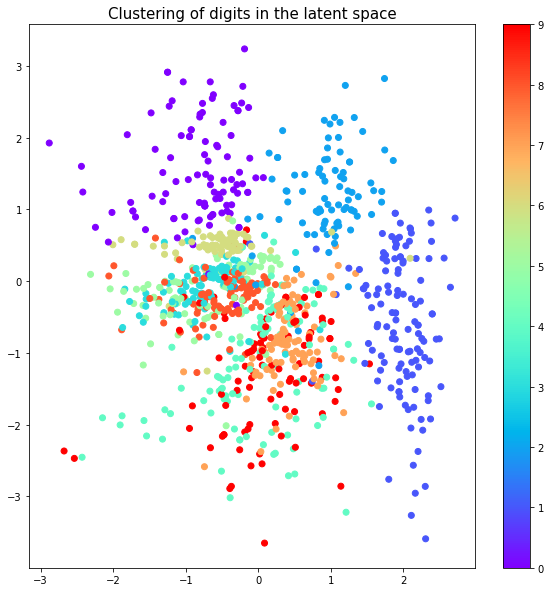

In [12]:
# 784차원 입력공간에서 2차원 잠재공간으로 변환
n_to_show = 1000  # 5000개의 관측치를 plotting
grid_size = 20
figsize = 8

# x_test에서 이미지 선택
example_idx = np.random.choice(range(len(x_test)), n_to_show)   # 5000개 선택
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

encoder = Model(input_img, z_mean)
z_points = np.array(encoder.predict(example_images))

plt.figure(figsize=(10, 10))
plt.scatter(z_points[:, 0], z_points[:, 1], c=example_labels, cmap='rainbow')
plt.colorbar()
plt.title('Clustering of digits in the latent space', fontsize=15)
plt.show()

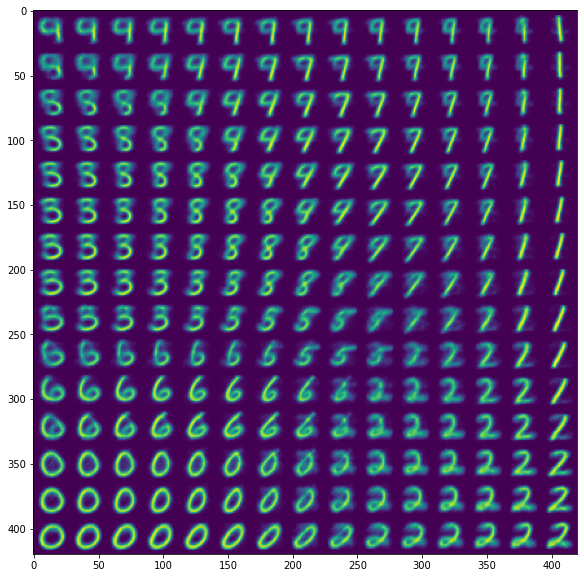

In [9]:
import matplotlib.pyplot as plt
from scipy.stats import norm
n=15   # 15개의 잠재변수 
image_size=28
figure=np.zeros((image_size*n,image_size*n))

z_x=norm.ppf(np.linspace(0.05,0.95,n))   # norm.ppf : 표준정규분포 확률변수 값 추출
z_y=norm.ppf(np.linspace(0.05,0.95,n))

for i,y in enumerate(z_y):
    for j, x in enumerate(z_x):
        z_sample=np.array([[x,y]])
        z_sample=np.tile(z_sample, batch_size).reshape(batch_size,2)
        x_decoded=decoder.predict(z_sample)
        digit=x_decoded[0].reshape(image_size, image_size)
        figure[i*image_size:(i+1)*image_size, j*image_size:(j+1)*image_size]=digit

plt.figure(figsize=(10,10))
plt.imshow(figure)
plt.show()   # 연속적으로 움직이는 숫자의 연속적인 분포 출력 